In [254]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from __future__ import unicode_literals
%matplotlib inline
params = {'legend.fontsize': 15, 'axes.labelsize': 15, 'xtick.labelsize': 15, 'ytick.labelsize': 15,
    'text.usetex': True, 'text.latex.unicode': True,
    'figure.figsize': (8, 8/1.6) }
plt.rcParams.update(params)
torch.set_default_dtype(torch.float64)

In [255]:
MAX = 1

def random(n, M = MAX):
    return 2 * (np.random.random(n) - 0.5) * M
    
def log_reg(x, A):
    s = torch.zeros(1)
    for i in range(A.shape[0]):
        s += torch.log(1 + torch.exp(torch.matmul(A[i], x)))
    return s

def grad_logreg(x, A):
    grad = torch.zeros(n)
    for i in range(A.shape[0]):
        Ai_x = torch.matmul(A[i], x)
        exp_Ai_x = torch.exp(Ai_x)
        grad += exp_Ai_x / (1 + exp_Ai_x) * A[i]
    return grad

def L_logreg(A):
    matr = torch.zeros([A.shape[1], A.shape[1]])
    for k in range(A.shape[0]):
        a_ = A[k]
        for i in range(A.shape[1]):
            for j in range(0, A.shape[1]):
                matr[i][j] += a_[i] * a_[j]   
    return matr.norm()

def L3_logreg(A):
    tens4 = torch.zeros([A.shape[1], A.shape[1], A.shape[1], A.shape[1]])
    for k in range(A.shape[0]):
        tens = torch.zeros([A.shape[1], A.shape[1], A.shape[1], A.shape[1]])
        for i in range(A.shape[1]):
            tens3 = torch.zeros([A.shape[1], A.shape[1], A.shape[1]])
            for j in range(A.shape[1]):
                tens2 = torch.zeros([A.shape[1], A.shape[1]])
                for l in range(A.shape[1]):
                    for m in range(A.shape[1]):
                        tens2[i][j] = A[k][i] * A[k][j] 
                tens3[j] = tens2
            tens[i] = tens3             
        tens4 += tens
    return tens4.norm()

In [256]:
class Iterations:
    def __init__(self, x, iters):
        self.x = x
        self.iters = iters
        
def caution(x):
    if(x.requires_grad):
        print('Input should not require grad')
        return True
    return False

def gradient(f, x):
    if(caution(x)):
        return
    x = torch.tensor(x, requires_grad = True)
    return torch.autograd.grad(outputs = f(x), inputs = x)[0].detach()

def gradient2(f, x):
    if(caution(x)):
        return
    x = torch.tensor(x, requires_grad = True)
    grad = torch.autograd.grad(outputs = f(x), inputs = x, create_graph = True)[0]
    grad2 = torch.zeros([x.shape[0], x.shape[0]])
    for i in range(x.shape[0]):
        grad2[i] = torch.autograd.grad(outputs = grad[i], inputs = x, create_graph = True)[0]
    return grad2.detach()

def gradient3(f, x):
    if(caution(x)):
        return
    x = torch.tensor(x, requires_grad = True)
    grad = torch.autograd.grad(outputs = f(x), inputs = x, create_graph = True)[0]
    grad2 = torch.zeros([x.shape[0], x.shape[0]])
    for i in range(x.shape[0]):
        grad2[i] = torch.autograd.grad(outputs = grad[i], inputs = x, create_graph = True)[0]
    grad3 = torch.zeros([x.shape[0], x.shape[0], x.shape[0]])
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            grad3[i][j] = torch.autograd.grad(outputs = grad2[i][j], inputs = x, create_graph = True)[0]
    return grad3.detach()

In [257]:
def NAG(f, x_0, gradient, L, eps = 1e-10, max_iter = 1e5):
    iterations = [x_0]
    k = 0
    y_0 = x_0
    gradient_x0 = gradient(x_0)
    
    while(len(iterations) <= max_iter):
        if(gradient_x0.norm() <= eps):
            break
        k += 1
        
        x_k = y_0 - 1./L * gradient(y_0)
        y_k = x_k + (k - 1.)/(k + 2.) * (x_k - x_0)
        
        if(f(x_k) > f(x_0) + torch.matmul(gradient_x0, x_k - x_0) + L/2. * (x_k - x_0).norm()):
            L *= 2
            k -= 1
            continue 
            
        iterations.append(x_k)
        gradient_x0 = gradient(x_k)
        x_0 = x_k
        y_0 = y_k
        
    if(len(iterations) >= max_iter):
        print('NAG did not manage to find precise enough solution')      
    return Iterations(x_k, iterations)

In [258]:
def fNAG(f, x_0, gradient, stop_cr, L, max_iter = 1e5):
    f_opt, eps = stop_cr
    iterations = [x_0]
    k = 0
    y_0 = x_0
    
    while(len(iterations) <= max_iter):
        if(abs(f(x_0) - f_opt) <= eps):
            break
        k += 1
        
        x_k = y_0 - 1./L * gradient(y_0)
        y_k = x_k + (k - 1.)/(k + 2.) * (x_k - x_0)
        
        iterations.append(x_k)
        x_0 = x_k
        y_0 = y_k
        
    if(len(iterations) >= max_iter):
        print('fNAG did not manage to find precise enough solution')   
    return Iterations(x_k, iterations)

In [260]:
def b_r(x, y, x_k, L_3, grad_r_x, grad2_f_xk):
    def r(x):   
        return 0.5 * torch.matmul(torch.matmul(grad2_f_xk, x - x_k), x - x_k) + L_3 * (x - x_k).norm()**4 / 4. 
    
    return r(y) - r(x) - torch.matmul(grad_r_x, y - x)

def g_phi_tau(y, f, x, grad_f_x, grad2_f_x, tau, L_3):
    
    return grad_f_x + torch.matmul(grad2_f_x, y - x) + 0.5 * 1./tau**2 * (
    gradient(f, x + tau * (y - x)) + gradient(f, x - tau * (y - x)) - 2. * grad_f_x
    ) + L_3 * (y - x).norm()**2 * (y - x)

def g_phi(y, f, x, L_3):
    
    return gradient(f, x) + torch.matmul(gradient2(f, x), y - x) + 0.5 * torch.matmul(torch.matmul(
    gradient3(f, x), y - x), y - x
    ) + L_3 * (y - x).norm()**2 * (y - x)
    
def model(y, f, x, L_3):
    
    return torch.matmul(gradient(f, x), y - x) +  1./2 * torch.matmul(torch.matmul(
    gradient2(f, x), y - x), y - x) + 1./6 * torch.matmul(torch.matmul(torch.matmul(
    gradient3(f, x), y - x), y - x), y - x) + L_3/(4.) * (y - x).norm()**4 

In [261]:
def BDGM_oracle_factor(len_iters):
    return n + 1 + 3 * len_iters

def NAG_oracle_factor(len_iters):
    return 1 * len_iters

def HyperFast_oracle_factor(len_iters, BDGM_iters):
    return 1 + BDGM_oracle_factor(BDGM_iters) + 1 * len_iters 

In [262]:
def BDGM(f, x, L_3, tau, axil_eps, axil_iter, max_iter = 3e2):
    iterations = []
    grad2_f_x = gradient2(f, x)
    grad_f_x = gradient(f, x)
    y_k = x
    S = 2. * ((2 + 2**0.5) / L_3 * grad_f_x.norm())**(1./3)
    delt = 1e-6
    ###delt = eps**1.5 / (grad_f_x.norm()**0.5 + grad2_f_x.norm()**1.5 / L_3**0.5)
    ###tau = 3. * delt / (8 * (2 + 2**0.5) * grad_f_x.norm())
    L = 1.
    while(len(iterations) <= max_iter):
        iterations.append(y_k)
        
        g = g_phi_tau(y_k, f, x, grad_f_x, grad2_f_x, tau, L_3)
        grad_f_yk = gradient(f, y_k)
        if((g.norm() <= 1./6 * grad_f_yk.norm() - delt) | (1./6 * grad_f_yk.norm() - delt <= 0)):
            break
              
        grad_r_yk = torch.matmul(grad2_f_x, y_k - x) + L_3 * (y_k - x).norm()**2 * (y_k - x)
        g_br = lambda y: torch.matmul(g, y - y_k) + 2 * (1 + 1./2**0.5) * b_r(y_k, y, x, L_3, grad_r_yk, grad2_f_x)
        grad_g_br = lambda y: g + 2 * (1 + 1./2**0.5) * (
            torch.matmul(grad2_f_x, y - x) + L_3 * (y - x).norm()**2 * (y - x) - grad_r_yk)
        
        nag_out = NAG(f = g_br, x_0 = y_k, gradient = grad_g_br, L = L, eps = axil_eps, max_iter = axil_iter)
        while(len(nag_out.iters) >= axil_iter):
            if(L >= 1e6):
                break
            L *= 10
            nag_out = NAG(f = g_br, x_0 = y_k, gradient = grad_g_br, L = L, eps = axil_eps, max_iter = axil_iter)
            
        y_k = nag_out.x
        if((y_k - x).norm() > S):
            print('Solution of axiliary problem is beyond the feasible set BDGM')
            
    if(len(iterations) >= max_iter):
            print('BDGM did not manage to find precise enough solution')
    return Iterations(y_k, iterations)

In [263]:
def bin_srch(f, x_bound, y_bound, max_iter = 20):
    iterations = []
    x_0, x_1 = x_bound
    y_0, y_1 = y_bound
    
    while(len(iterations) <= max_iter):
        x = (x_0 + x_1) / 2.
        f_x = f(x)
        iterations.append(x)
        if(f_x >= y_0):
            if(f_x <= y_1):
                if(len(iterations) >= max_iter):
                    print('bin_srch function has failed')
                return Iterations(x, iterations)
            else:
                x_0 = x
        else:
            x_1 = x

In [264]:
def HyperFast(f, L_3, tau, stop_cr, axil_eps, axil_iter, max_iter):
    f_opt, eps = stop_cr
    BDGM_iters = []
    def BDGM_(x, axil_eps = axil_eps, axil_iter = axil_iter):
        iters = BDGM(f, x, L_3, tau, axil_eps, axil_iter)
        BDGM_iters.append(len(iters.iters))
        return iters.x
    iterations = []
    A_k = 0.
    y_k = x_k = x_k_v = torch.zeros(n)
    
    y_k = BDGM_(x_k_v)
    lam_k = (7./12) / (0.75 * L_3 * (y_k - x_k_v).norm()**2)         
    a_k = 0.5 * (lam_k + (lam_k**2 + 4 * lam_k * A_k)**0.5)
    A_k = A_k + a_k
    x_k = x_k - a_k * gradient(f, y_k)
    iterations.append(y_k)
    
    while(len(iterations) <= max_iter):  
        xi_t = lambda t: (1 - t)**2 * A_k * (1.5 * L_3) / (2 * t) * (
            BDGM_((1 - t) * x_k + t * y_k) - ((1 - t) * x_k + t * y_k)).norm()**2
        t = bin_srch(xi_t, [0., 1.], [0.5, 0.75]).x
        
        x_k_v = (1 - t) * x_k + t * y_k
        y_k = BDGM_(x_k_v)
        lam_k = (1 - t)**2 * A_k / t
        
        C = (lam_k * 0.75 * L_3 * (y_k - x_k_v).norm()**2)
        if((C < 0.5) | (C > 0.75)):
            print('Wrong lambda parameter was found during the work of HyperFast')
            continue
        
        a_k = 0.5 * (lam_k + (lam_k**2 + 4 * lam_k * A_k)**0.5)
        A_k = A_k + a_k
        x_k = x_k - a_k * gradient(f, y_k)
        
        iterations.append(y_k)
        if(len(iterations) % 10 == 0):
            print(len(iterations), f(y_k), f_opt)
        if(abs(f(y_k) - f_opt) <= eps):
            break
    
    if(len(iterations) >= max_iter):
        print('HyperFast did not manage to find precise enough solution')
    return Iterations(y_k, iterations), sum(BDGM_iters)

In [266]:
ns = range(10, 201)[::10]
tau = 0.0002
eps = 1e-4
max_iter = 5e2
axil_eps = 1e-10
axil_iter = 3e3
nag_oracle_compl = []
hf_oracle_compl = []

for n in ns:
    len_nag_iters = []
    len_hf_iters = []
    
    for i in range(10):
    
        x_0 = torch.tensor(random(n))
        m = n
        A = torch.zeros([m, n])
        for i in range(0, m):
            A[i] = torch.tensor(random(n, M = 1))
        f = lambda x: log_reg(x, A)
        grad_f = lambda x: grad_logreg(x, A)
        L = L_logreg(A)
        L_3 = 1. ###

        x_opt = NAG(f, x_0, grad_f, L = L, eps = 1e-8, max_iter = 1e5).x
        f_opt = f(x_opt)
        stop_cr = (f_opt, eps)

        nag_iters = fNAG(f, x_0, grad_f, stop_cr, L = L)
        hf_iters, BDGM_iters = HyperFast(f, L_3, tau, stop_cr, axil_eps, axil_iter, max_iter)

        len_nag_iters.append(NAG_oracle_factor(len(nag_iters.iters)))
        len_hf_iters.append(HyperFast_oracle_factor(len(hf_iters.iters), BDGM_iters))
        
    
    nag_oracle_compl.append([np.mean(len_nag_iters), np.std(len_nag_iters)])
    hf_oracle_compl.append([np.mean(len_hf_iters), np.std(len_hf_iters)])
    print("Iteration complete")
    
    print(n, nag_oracle_compl[-1], hf_oracle_compl[-1])

NAG did not manage to find precise enough solution
10 tensor([0.3657]) tensor([9.3142e-08])
20 tensor([0.0281]) tensor([9.3142e-08])
30 tensor([0.0047]) tensor([9.3142e-08])
40 tensor([0.0012]) tensor([9.3142e-08])
50 tensor([0.0004]) tensor([9.3142e-08])
60 tensor([0.0002]) tensor([9.3142e-08])
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find precise enoug

60 tensor([0.0003]) tensor([1.4103e-07])
70 tensor([0.0001]) tensor([1.4103e-07])
Iteration complete
10 [2367.3, 920.8390793184225] [5915.0, 1963.4365790623337]
NAG did not manage to find precise enough solution
10 tensor([0.4370]) tensor([3.0337e-07])
NAG did not manage to find precise enough solution
20 tensor([0.0301]) tensor([3.0337e-07])
30 tensor([0.0048]) tensor([3.0337e-07])
40 tensor([0.0012]) tensor([3.0337e-07])
50 tensor([0.0004]) tensor([3.0337e-07])
60 tensor([0.0002]) tensor([3.0337e-07])
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
10 tensor([0.1979]) tensor([1.4666e-07])
20 tensor([0.0107]) tensor([1.4666e-07])
30 tensor([0.0016]) tensor([1.4666e-07])
40 tensor([0.0004]) tensor([1.4666e-07])
50 tensor([0.0001]) tensor([1.4666e-07])
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find prec

NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
10 tensor([0.5096]) tensor([7.4016e-07])
20 tensor([0.0286]) tensor([7.4016e-07])
30 tensor([0.0044]) tensor([7.4016e-07])
40 tensor([0.0011]) tensor([7.4016e-07])
50 tensor([0.0003]) tensor([7.4016e-07])
60 tensor([0.0001]) tensor([7.4016e-07])
NAG did not manage to find precise enough solution
10 tensor([0.5885]) tensor([7.6860e-07])
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
20 tensor([0.0343]) tensor([7.6860e-07])
30 tensor([0.0053]) tensor([7.6860e-07])
40 tensor([0.0013]) tensor([7.6860e-07])
50 tensor([0.0004]) tensor([7.6860e-07])
60 tensor([0.0002]) tensor([7.6860e-07])
NAG did not manage to find precise enough solution
10 tensor([0.1231]) tensor([3.1645e-07])
20 tensor([0.0064]) tensor([3.1645e-07])
30 tensor([0.0009]) tensor([3.1645e-07])
40 tensor([0.0002]) tensor([

NAG did not manage to find precise enough solution
10 tensor([0.3331]) tensor([9.8200e-07])
NAG did not manage to find precise enough solution
20 tensor([0.0173]) tensor([9.8200e-07])
30 tensor([0.0025]) tensor([9.8200e-07])
40 tensor([0.0006]) tensor([9.8200e-07])
50 tensor([0.0002]) tensor([9.8200e-07])
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
10 tensor([0.2541]) tensor([8.2640e-07])
20 tensor([0.0133]) tensor([8.2640e-07])
30 tensor([0.0020]) tensor([8.2640e-07])
40 tensor([0.0005]) tensor([8.2640e-07])
50 tensor([0.0001]) tensor([8.2640e-07])
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
10 tensor([0.4811]) tensor([1.2603e-06])
NAG did not manage to find precise enough solution
NAG did not manage to find precise enou

20 tensor([0.0263]) tensor([1.8299e-06])
30 tensor([0.0040]) tensor([1.8299e-06])
40 tensor([0.0010]) tensor([1.8299e-06])
50 tensor([0.0003]) tensor([1.8299e-06])
60 tensor([0.0001]) tensor([1.8299e-06])
NAG did not manage to find precise enough solution
10 tensor([0.4486]) tensor([1.8266e-06])
NAG did not manage to find precise enough solution
20 tensor([0.0243]) tensor([1.8266e-06])
30 tensor([0.0037]) tensor([1.8266e-06])
40 tensor([0.0009]) tensor([1.8266e-06])
50 tensor([0.0003]) tensor([1.8266e-06])
60 tensor([0.0001]) tensor([1.8266e-06])
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
10 tensor([0.6525]) tensor([2.2719e-06])
20 tensor([0.0363]) tensor([2.2719e-06])
30 tensor([0.0056]) tensor([2.2719e-06])
40 tensor([0.0014]) tensor([2.2719e-06])
50 tensor([0.0004]) tensor([2.2719e-06])
60 tensor([0.0002]) tensor([2.2719e-06])
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough soluti

60 tensor([0.0002]) tensor([3.0336e-06])
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
10 tensor([0.5152]) tensor([2.8272e-06])
20 tensor([0.0288]) tensor([2.8272e-06])
30 tensor([0.0044]) tensor([2.8272e-06])
40 tensor([0.0011]) tensor([2.8272e-06])
50 tensor([0.0003]) tensor([2.8272e-06])
60 tensor([0.0001]) tensor([2.8272e-06])
NAG did not manage to find precise enough solution
10 tensor([0.4509]) tensor([2.4245e-06])
20 tensor([0.0236]) tensor([2.4245e-06])
30 tensor([0.0035]) tensor([2.4245e-06])
40 tensor([0.0008]) tensor([2.4245e-06])
50 tensor([0.0003]) tensor([2.4245e-06])
60 tensor([0.0001]) tensor([2.4245e-06])
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
10 tensor([0.7420]) tensor([3.3972e-06])
20 tensor([0.0418]

50 tensor([0.0006]) tensor([4.6383e-06])
60 tensor([0.0002]) tensor([4.6383e-06])
Iteration complete
120 [18994.3, 1785.6043262716407] [7408.5, 636.3016973103246]
NAG did not manage to find precise enough solution
10 tensor([0.3523]) tensor([2.9935e-06])
NAG did not manage to find precise enough solution
20 tensor([0.0182]) tensor([2.9935e-06])
30 tensor([0.0027]) tensor([2.9935e-06])
40 tensor([0.0006]) tensor([2.9935e-06])
50 tensor([0.0002]) tensor([2.9935e-06])
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
NAG did not manage to find precise enough solution
10 tensor([1.2483]) tensor([6.6299e-06])
20 tensor([0.0693]) tensor([6.6299e-06])
30 tensor([0.0106]) tensor([6.6299e-06])
40 tensor([0.0026]) tensor([6.6299e-06])
50 tensor([0.0008]) tensor([6.6299e-06])
60 tensor([0.0003]) tensor([6.6299e-06])
70 tensor([0.0001]) tensor([6.6299e-06])
NAG did not manage to find precise enou

KeyboardInterrupt: 

In [267]:
nag_oracle_compl = np.array(nag_oracle_compl)
hf_oracle_compl = np.array(hf_oracle_compl)

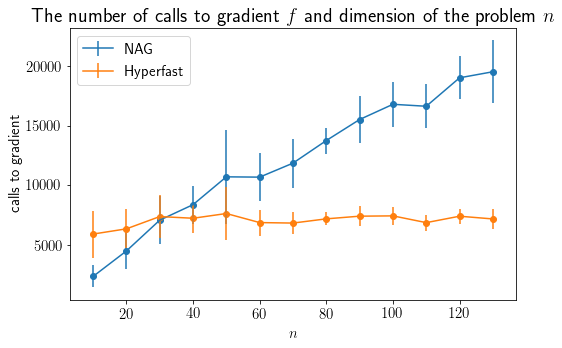

In [272]:
plt.errorbar(ns[:len(nag_oracle_compl)], nag_oracle_compl[:,0], yerr = nag_oracle_compl[:,1], label = 'NAG')
plt.scatter(ns[:len(nag_oracle_compl)], nag_oracle_compl[:,0])
plt.errorbar(ns[:len(hf_oracle_compl)], hf_oracle_compl[:,0], yerr = hf_oracle_compl[:,1], label = 'Hyperfast')
plt.scatter(ns[:len(hf_oracle_compl)], hf_oracle_compl[:,0])
plt.xlabel(r'$n$', size = 15)
plt.ylabel('calls to gradient', size = 15)
plt.legend()
plt.title(r'The number of calls to gradient $f$ and dimension of the problem $n$', size = 20)
plt.savefig('HF.pdf')